In [2]:
import numpy as np
from sklearn import metrics
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
class AdaBound():


    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), final_lr=0.1, gamma=1e-3,
                 eps=1e-8, weight_decay=0, amsbound=False):
        
        if lr < 0 or eps < 0 or betas[0] <0 or betas[0]>=1 or betas[1] <0 or betas[1]>=1 or final_lr < 0 or gamma <0 or gamma>=1:
            print("Invalid one of the parametrs. Must be : lr>=0; eps>=0; 0<=bets[0]<1; 0<=bets[1]<1; final_lr>=0; gamma>=0")
               
        self.lr = lr
        self.beta1 = betas[0]
        self.beta2 = betas[1]
        self.eps = eps
        self.gamma = gamma
        self.final_lr = final_lr
        self.params = params
        
    def step(self, state=1):
        for nn, p in enumerate(self.params):
            if state == 1:
                self.f, self.s = {}, {}
                for l in range(len(self.params)):
                    self.f["dw" + str(l + 1)] = self.s["dw" + str(l+1)] =np.zeros_like(self.params[l].weight)
                    self.f["db" + str(l + 1)] = self.s["db" + str(l+1)] = np.zeros_like(self.params[l].bias)

            self.f["dw" + str(nn + 1)] = self.beta1 * self.f["dw" + str(nn + 1)] + (1 - self.beta1) * p.grads['dw']
            self.f["db" + str(nn + 1)] = self.beta1 * self.f["db" + str(nn + 1)] + (1 - self.beta1) * p.grads['db']
            self.s["dw" + str(nn + 1)] = self.beta2 * self.s["dw" + str(nn + 1)] + (1 - self.beta2) * np.power(p.grads['dw'], 2)
            self.s["db" + str(nn + 1)] = self.beta2 * self.s["db" + str(nn + 1)] + (1 - self.beta2) * np.power(p.grads['db'], 2)

                
            denom_w = np.sqrt(self.s["dw" + str(nn + 1)]) + self.eps
            denom_b = np.sqrt(self.s["db" + str(nn + 1)]) + self.eps

            bias_correction1 = 1 - self.beta1 ** state
            bias_correction2 = 1 - self.beta2 ** state
            step_size = self.lr * np.sqrt(bias_correction2)/ bias_correction1

            final_lr = self.final_lr * self.lr / self.lr
            lower_bound = final_lr * (1 - 1 / (self.gamma * state + 1))
            upper_bound = final_lr * (1 + 1 / (self.gamma * state + self.eps))

            step_size_w = np.clip(np.full_like(denom_w, step_size) / denom_w, lower_bound, upper_bound) * self.f["dw" + str(nn + 1)] 
            step_size_b = np.clip(np.full_like(denom_b, step_size)/ denom_b, lower_bound, upper_bound) * self.f["db" + str(nn + 1)]

            p.weight -= step_size_w
            p.bias -= step_size_b

In [5]:
def ReLU(x):
    return x * (x > 0)

def ReLUDerivative(x):
    return 1. * (x > 0)

def zero_pad(X, pad):

    X_pad = np.pad(X, ((0, 0), (pad, pad), (pad, pad), (0, 0)), 'constant', constant_values=(0, 0))

    return X_pad

def softmax(X):
    return np.exp(X) / np.sum(np.exp(X), axis=0)

def sigmoid(X):
    return 1/(1 + np.exp(-X))

def conv_single_step(a_slice_prev, W, b):
    s = np.multiply(a_slice_prev, W)
    Z = np.sum(s)
    Z = Z + float(b)

    return Z

def create_mask_from_window(x):
    mask = (x == np.max(x))
    return mask

def distribute_value(dz, shape):
    
    (n_H, n_W) = shape
    average = dz / (n_H * n_W)
    a = np.ones(shape) * average
    
    return a

In [6]:
def linear_forward( x, w, b):
    return np.dot(w, x) + b, (x,w,b)

def ReLU_backward( dX, X):
    return np.where(X>0,dX,0)

In [7]:
def pool_forward(A_prev, hparameters, mode="max"):

    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape

    f = hparameters["f"]
    stride = hparameters["stride"]

    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev

    A = np.zeros((m, n_H, n_W, n_C))

    for i in range(m): 
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C): 
                    vert_start = stride * w
                    vert_end = stride * w + f
                    horiz_start = stride * h
                    horiz_end = stride * h + f

                    a_prev_slice = A_prev[i, vert_start:vert_end, horiz_start:horiz_end, c]

                    if mode == "max":
                        A[i, h, w, c] = np.max(a_prev_slice)
                    elif mode == "average":
                        A[i, h, w, c] = np.mean(a_prev_slice)

    cache = (A_prev, hparameters)

    assert (A.shape == (m, n_H, n_W, n_C))

    return A, cache

def pool_backward(dA, cache, mode = "max"):

    

    (A_prev, hparameters) = cache
    
    stride = hparameters["stride"]
    f = hparameters["f"]
    
    m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    m, n_H, n_W, n_C = dA.shape
    
    dA_prev = np.zeros(A_prev.shape)
    
    for i in range(m):
        a_prev = A_prev[i]
        for h in range(n_H):       
            for w in range(n_W): 
                for c in range(n_C):
                    vert_start  = h*stride
                    vert_end    = vert_start + f
                    horiz_start = w*stride
                    horiz_end   = horiz_start + f
                    
                    if mode == "max":
                        a_prev_slice = a_prev[vert_start:vert_end, horiz_start:horiz_end, c]
                        mask = create_mask_from_window(a_prev_slice)
                        dA_prev[i, vert_start:vert_end, horiz_start:horiz_end, c] += np.multiply(mask, dA[i, h, w, c])
                        
                    elif mode == "average":
                        da = dA[i, h, w, c]
                        shape = (f, f)
                        dA_prev[i, vert_start:vert_end, horiz_start:horiz_end, c] += distribute_value(da, shape)
                        
    
    assert(dA_prev.shape == A_prev.shape)
    
    return dA_prev

In [8]:
class Conv2d:

    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0, pooling=False):

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.pooling = pooling

        self.cache = None

        self._init_weights()

    def _init_weights(self):
        self.weight = 1e-3 * np.random.randn(self.kernel_size, self.kernel_size, self.in_channels, self.out_channels)
        self.bias = np.zeros((1, 1, 1, self.out_channels))

    def conv_forward(self, x, activation='relu'):


        A_prev = x
        W = self.weight
        B = self.bias
        
        m, n_H_prev, n_W_prev, n_C_prev = x.shape
        f, f, n_C_prev, n_C = W.shape

        stride = self.stride
        pad = self.padding

        n_H = int((n_H_prev - f + (2 * pad)) / stride + 1)
        n_W = int((n_W_prev - f + (2 * pad)) / stride + 1)

        Z = np.zeros((m, n_H, n_W, n_C))
        a = np.zeros((m, n_H, n_W, n_C))
        
        A_prev_pad = zero_pad(A_prev, pad)
        for i in range(m):
            a_prev_pad = A_prev_pad[i]
            for h in range(n_H):
                vert_start = h * stride
                vert_end = h * stride + f
                for w in range(n_W):
                    horiz_start = w * stride 
                    horiz_end = w * stride + f
                    for c in range(n_C):
                        a_slice_prev = a_prev_pad[vert_start: vert_end, horiz_start: horiz_end, :]

                        z_slice = Z[i, h, w, c] = conv_single_step(a_slice_prev, W[:,:,:, c], B[:, :, :, c])

                        if activation == 'relu':
                            a[i, h, w, c] = ReLU(z_slice)

        assert(Z.shape == (m, n_H, n_W, n_C))

        if self.pooling == True:
            a, self.pool_cache = pool_forward(a, hparameters=dict(f=2, stride=2))
            
        self.cache = (A_prev, Z)

        return a


    def backward(self, dA):

        if self.pooling == True:
            dA = pool_backward(dA, self.pool_cache)
        
        stride = self.stride
        pad = self.padding
        W = self.weight
        
        (A_prev, Z) = self.cache
        dZ = ReLUDerivative(Z) * dA

        m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
        f, f, n_C_prev, n_C = W.shape
        m, n_H, n_W, c = dZ.shape               

        dA_prev = np.zeros((m, n_H_prev, n_W_prev, n_C_prev))
        dw = np.zeros((f, f, n_C_prev, n_C))
        db = np.zeros((1, 1, 1, n_C))

        A_prev_pad = zero_pad(A_prev, pad)
        dA_prev_pad = zero_pad(dA_prev, pad)

        for i in range(m):
            A_prev_pad_m = A_prev_pad[i]
            dA_prev_pad_m = dA_prev_pad[i]
            for h in range(n_H):
                vert_start = h * stride
                vert_end = h * stride + f
                for w in range(n_W):
                    horiz_start = w * stride
                    horiz_end = w * stride + f
                    for c in range(n_C):

                        a_slice = A_prev_pad_m[vert_start:vert_end, horiz_start:horiz_end, :]

                        dA_prev_pad_m[vert_start:vert_end, horiz_start:horiz_end, :] += W[:, :, :, c] * dZ[i, h, w, c]
                        dw[:, :, :, c] += a_slice * dZ[i, h, w, c]
                        db[:, :, :, c] += dZ[i, h, w, c]
          
            dA_prev[i] = dA_prev_pad_m[pad:-pad, pad:-pad, :]
        
        dw /= m
        db /= m

        grads = dict(da_prev=dA_prev, dw=dw, db=db)
        self.grads = grads
        return grads

In [13]:
class Linear():   

    def __init__(self, in_features, out_features, activation='relu', eps = 0.000001):

        self.activation = activation
        self.eps = eps
        self.weight = np.random.randn(out_features, in_features) * 0.01
        self.bias = np.zeros((out_features, 1))
        
    def l_linear_forward(self, x):

        self.caches = []
        if self.activation == "relu":
            Z, linear_cache = linear_forward(x, self.weight, self.bias)
            A, activation_cache = ReLU(Z), Z
        
        if self.activation =='softmax':
            Z, linear_cache = linear_forward(x, self.weight, self.bias)
            A, activation_cache = softmax(Z), Z
        cache = (linear_cache, activation_cache)
        self.caches.append(cache)

        return A

    def compute_cost(self, AL, Y):
    
        Y = Y.reshape(AL.shape)
        loss = -np.sum(Y*np.log(AL) + (1-Y)*np.log(1-AL))/len(Y)
        self.dAL = AL - Y

        return loss
    
    def linear_backward(self, dZ, cache):

        A_prev, W, b = cache
        factor = 1 / A_prev.shape[1]
        dW = factor*np.dot(dZ, A_prev.T)
        db = factor*np.sum(dZ, axis = 1, keepdims = True)
        dA_prev = np.dot(W.T, dZ)

        return dA_prev, dW, db

    def backward(self, dA_prev=0.5):

        grads = {}
        linear_cache, activation_cache = self.caches[0]
        if self.activation == "relu":
            dZ = ReLU_backward(dA_prev, activation_cache)
            dA_prev, dw, db = self.linear_backward(dZ, linear_cache)
        if self.activation == "softmax":
            dZ = self.dAL
            dA_prev, dw, db = self.linear_backward(dZ, linear_cache)
        grads["da_prev"], grads["dw"], grads["db"] = dA_prev, dw, db
        self.grads = grads
        return grads

In [14]:
class VGG16():
    def __init__(self, num_classes=10, shrink=7):

        self.layer1 = Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.layer2 = Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1, pooling=True)
        self.layer3 = Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.layer4 = Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1, pooling=True)
        self.layer5 = Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.layer6 = Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.layer7 = Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1, pooling=True)
        self.layer8 = Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.layer9 = Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.layer10 = Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1, pooling=True)
        self.layer11 = Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.layer12 = Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.layer13 = Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1, pooling=True)
        self.lnn1 = Linear(shrink*shrink*512, 4096)
        self.lnn2 = Linear(4096, 4096)
        self.lnn3 = Linear(4096, num_classes, activation='softmax')

        
    def forward(self, x, batch_size=1):
        out = self.layer1.conv_forward(x)
        out = self.layer2.conv_forward(out)
        out = self.layer3.conv_forward(out)
        out = self.layer4.conv_forward(out)
        out = self.layer5.conv_forward(out)
        out = self.layer6.conv_forward(out)
        out = self.layer7.conv_forward(out)
        out = self.layer8.conv_forward(out)
        out = self.layer9.conv_forward(out)
        out = self.layer10.conv_forward(out)
        out = self.layer11.conv_forward(out)
        out = self.layer12.conv_forward(out)
        out = self.layer13.conv_forward(out)
        out = out.reshape(-1, batch_size)
        out = self.lnn1.l_linear_forward(out)
        out = self.lnn2.l_linear_forward(out)
        out = self.lnn3.l_linear_forward(out)

        return out

    def backward(self, layers, batch_size=1):

        self.GR = []
        grads = self.lnn3.backward()
        self.GR.append(grads)

        for l in layers[0:2]: 
            grads = l.backward(grads['da_prev'])
            self.GR.append(grads)
        a_prev = self.layer13.cache[0]
        dim = int(a_prev.shape[1] / 2)
        grads['da_prev'] = grads['da_prev'].reshape(batch_size, dim, dim, 512)
        for l in layers[2:]: 
            grads = l.backward(grads['da_prev'])
            self.GR.append(grads)

        GR = self.GR

        return GR

In [15]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train = tf.image.resize(x_train, [32,32])
x_test = tf.image.resize(x_test, [32,32])

y_train = tf.keras.utils.to_categorical(y_train , num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test , num_classes=10)

In [19]:
shrink = 1
batch_size = 3
batch_count = 5
epochs = 5
num_epoch = 30

model = VGG16(num_classes=10, shrink=1)
params = list(model.__dict__.values())
opt = AdaBound(params, lr=1e-3, betas=(0.9, 0.999), final_lr=7.5e-3, gamma=1e-5,
                 eps=1e-8, weight_decay=0, amsbound=False)

x_dataloader = [x_train[index*batch_size:(index+1)*batch_size] for index in range(batch_count)]
y_dataloader = [y_train[index*batch_size:(index+1)*batch_size].reshape(10, batch_size) for index in range(batch_count)]


all_loss = []
accurace  = []
recall = []
precision = []
f1 = []

for i in range(0, epochs):
    print(f"Epoch #{i}")
    y_true, y_pred = [], []
    loss = 0

    for index in range(len(x_dataloader[0:1])):
        x = x_dataloader[index]
        y = y_dataloader[index]
        out = model.forward(x, batch_size)
        #assert 1==0
        loss = model.lnn3.compute_cost(out, y)
        loss += loss
        grads = model.backward(list(reversed(params))[1:], batch_size)
        opt.step(i+1)

        out, y = out.reshape(out.shape[1], out.shape[0]), y.reshape(y.shape[1], y.shape[0])

        y_true += list(np.argmax(out, axis=1))
        y_pred += list(np.argmax(y, axis=1))


    all_loss += [loss]
    accurace  += [metrics.accuracy_score(y_true, y_pred)]
    recall += [metrics.recall_score(y_true, y_pred, average='macro')]
    precision += [metrics.precision_score(y_true, y_pred, average='macro')]
    f1 += [metrics.f1_score(y_true, y_pred, average='macro')]
    print(f''' Loss: {loss},
Accurace : {accurace[-1]},
Recall(macro) : {recall[-1]}
Precision(macro) : {precision[-1]} 
F1(macro): {f1[-1]}
_________________________''')


Epoch #0


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 Loss: 1.95049784034869,
Accurace : 0.3333333333333333,
Recall(macro) : 0.1111111111111111
Precision(macro) : 0.3333333333333333 
F1(macro): 0.16666666666666666
_________________________
Epoch #1


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 Loss: 1.9454133170426893,
Accurace : 0.6666666666666666,
Recall(macro) : 0.5
Precision(macro) : 0.5 
F1(macro): 0.5
_________________________
Epoch #2
 Loss: 1.9357240004056766,
Accurace : 1.0,
Recall(macro) : 1.0
Precision(macro) : 1.0 
F1(macro): 1.0
_________________________
Epoch #3
 Loss: 1.9161873410125243,
Accurace : 1.0,
Recall(macro) : 1.0
Precision(macro) : 1.0 
F1(macro): 1.0
_________________________
Epoch #4
 Loss: 1.8755685540977698,
Accurace : 1.0,
Recall(macro) : 1.0
Precision(macro) : 1.0 
F1(macro): 1.0
_________________________


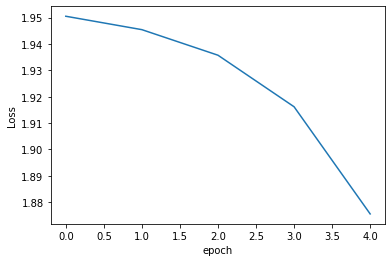

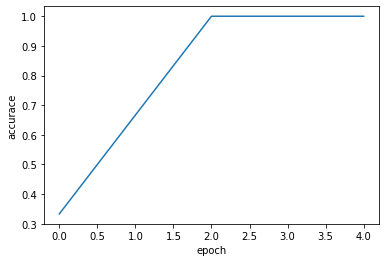

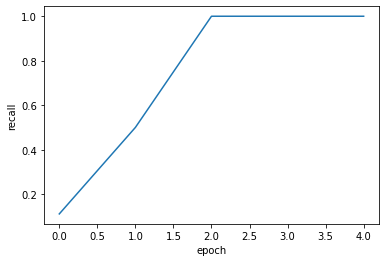

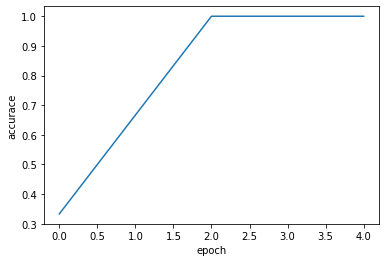

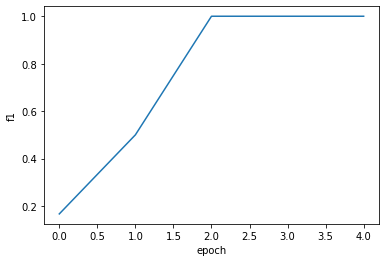

In [20]:
plt.plot(all_loss)
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.show()

plt.plot(accurace)
plt.ylabel('accurace')
plt.xlabel('epoch')
plt.show()

plt.plot(recall)
plt.ylabel('recall')
plt.xlabel('epoch')
plt.show()

plt.plot(accurace)
plt.ylabel('accurace')
plt.xlabel('epoch')
plt.show()

plt.plot(f1)
plt.ylabel('f1')
plt.xlabel('epoch')
plt.show()